## This script is used to calculate the ROC curve for the reference FWI and EXP3b with bootstrapping.

In [1]:
# ---------------------------------------------------------------------------------------------
# MODULES
# ---------------------------------------------------------------------------------------------
import os
import seaborn as sns
import pandas as pd
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dcopy
from sklearn.utils import resample
from python_functions_sklearn import Contingency_table, CT_metrics, compute_roc


In [2]:
# ---------------------------------------------------------------------------------------------
# SET DETAILS FIGURES
# ---------------------------------------------------------------------------------------------
font_title = 20
font_subtitle = 16
font_axes = 14
font_ticklabels = 12
font_text = 12
font_legend = 12

# colorblind proof:
palette = sns.color_palette('colorblind')

# Define colors
c_ref = palette[0]
c_EXP1 = palette[1]
c_EXP2 = palette[2]
c_EXP2b = palette[2]
c_EXP3 = 'tab:brown'
c_EXP3b = 'tab:brown'
c_EXP4 = palette[4]

# Define linestyles
ls_ref = 'solid'
ls_EXP1 = 'dotted'
ls_EXP2 = 'dashdot'
ls_EXP2b = 'dashed'
ls_EXP3 = (0, (3, 1, 1, 1, 1, 1))
ls_EXP3b = 'dashed'
ls_EXP4 = (0, (5, 1))

In [3]:
# ---------------------------------------------------------------------------------------------
# SPECIFY TIER AND CORRESPONDING PATHS
# ---------------------------------------------------------------------------------------------
Tier = 'Hortense'

if Tier == 'Hortense':
    path_ref = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/Reference'
    path_out = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/output/CDF_matched'
    path_fires = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/Fire_data'
    path_figs = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/output/Figures'
    path_peatlands = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/PEATCLSM'
    path_PEATMAP = '/dodrio/scratch/projects/2022_200/project_output/rsda/vsc33651/PEATBURN/Tropical/PEATMAP' \
                   '/Miettinen2016-PeatLCC900715'

elif Tier == 'Genius':
    path_ref = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/Reference'
    path_out = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/output/CDF_matched'
    path_fires = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/Fire_data'
    path_figs = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/output/Figures'
    path_peatlands = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/PEATCLSM'
    path_PEATMAP = '/staging/leuven/stg_00024/OUTPUT/jonasm/PEATBURN/Tropical/PEATMAP' \
                   '/Miettinen2016-PeatLCC900715'

else:
    print('Error: Tier can only be Hortense or Genius.')

peatland_types = ['TN', 'TD']
CDF_types = ['pixel']

In [4]:
# ---------------------------------------------------------------------------------------------
# LOAD FIRE DATASET
# ---------------------------------------------------------------------------------------------
fires_file = os.path.join(path_fires, 'Reformatted_table_Tim.csv')

fires = pd.read_csv(fires_file, header=0)
fires['start_date'] = pd.to_datetime(fires['start_date'])
# only get those fires that are in our domain and in peatclsm pixels:
fire_data = fires[fires['Drained_I'] >= 0].reset_index(drop=True)

times = pd.date_range('2002-01-01', '2018-12-31', freq='D')

fire_dates = pd.DatetimeIndex(fire_data.start_date)
fire_data = fire_data[fire_dates.year >= 2002].reset_index(drop=True)
fire_dates = fire_dates[fire_dates.year >= 2002]

fires_nat = dcopy(fire_data)
fires_nat = fires_nat[fires_nat['Drained_I'] == 0].reset_index(drop=True)
fire_nat_dates = pd.DatetimeIndex(fires_nat.start_date)
fire_nat_dates = fire_nat_dates[fire_nat_dates.year >= 2002]
fires_dra = dcopy(fire_data)
fires_dra = fires_dra[fires_dra['Drained_I'] == 1].reset_index(drop=True)
fire_dra_dates = pd.DatetimeIndex(fires_dra.start_date)
fire_dra_dates = fire_dra_dates[fire_dra_dates.year >= 2002]

In [5]:
# ---------------------------------------------------------------------------------------------
# LOAD FWI DATASETS
# ---------------------------------------------------------------------------------------------
## Natural
# Reference:
ds_ref_nat = Dataset(os.path.join(path_ref, 'FWI_masked_Nat.nc'), 'r')
FWI_M2_nat = ds_ref_nat['MERRA2_FWI'][0:6209, :, :].data

# EXP1:
ds_EXP1_nat = Dataset(os.path.join(path_out, 'FWI_zbar_DC_TN_pixel.nc'), 'r')
FWI_EXP1_nat = ds_EXP1_nat['MERRA2_FWI'][0:6209, :, :].data

# EXP2:
ds_EXP2_nat = Dataset(os.path.join(path_out, 'FWI_sfmc_DMC_TN_pixel.nc'), 'r')
FWI_EXP2_nat = ds_EXP2_nat['MERRA2_FWI'][0:6209, :, :].data

# EXP3:
ds_EXP3_nat = Dataset(os.path.join(path_out, 'FWI_sfmc_FFMC_TN_pixel.nc'), 'r')
FWI_EXP3_nat = ds_EXP3_nat['MERRA2_FWI'][0:6209, :, :].data

# EXP4:
ds_EXP4_nat = Dataset(os.path.join(path_out, 'FWI_zbar_FWI_TN_pixel.nc'), 'r')
FWI_EXP4_nat = ds_EXP4_nat['zbar'][0:6209, :, :].data

# EXP2b:
ds_EXP2b_nat = Dataset(os.path.join(path_out, 'FWI_zbar_DMC_TN_pixel.nc'), 'r')
FWI_EXP2b_nat = ds_EXP2b_nat['MERRA2_FWI'][0:6209, :, :].data

# EXP3b:
ds_EXP3b_nat = Dataset(os.path.join(path_out, 'FWI_zbar_FFMC_TN_pixel.nc'), 'r')
FWI_EXP3b_nat = ds_EXP3b_nat['MERRA2_FWI'][0:6209, :, :].data

## Drained
# Reference:
ds_ref_dra = Dataset(os.path.join(path_ref, 'FWI_masked_Dra.nc'), 'r')
FWI_M2_dra = ds_ref_dra['MERRA2_FWI'][0:6209, :, :].data

# EXP1:
ds_EXP1_dra = Dataset(os.path.join(path_out, 'FWI_zbar_DC_TD_pixel.nc'), 'r')
FWI_EXP1_dra = ds_EXP1_dra['MERRA2_FWI'][0:6209, :, :].data

# EXP2:
ds_EXP2_dra = Dataset(os.path.join(path_out, 'FWI_sfmc_DMC_TD_pixel.nc'), 'r')
FWI_EXP2_dra = ds_EXP2_dra['MERRA2_FWI'][0:6209, :, :].data

# EXP3:
ds_EXP3_dra = Dataset(os.path.join(path_out, 'FWI_sfmc_FFMC_TD_pixel.nc'), 'r')
FWI_EXP3_dra = ds_EXP3_dra['MERRA2_FWI'][0:6209, :, :].data

# EXP4:
ds_EXP4_dra = Dataset(os.path.join(path_out, 'FWI_zbar_FWI_TD_pixel.nc'), 'r')
FWI_EXP4_dra = ds_EXP4_dra['zbar'][0:6209, :, :].data

# EXP2b:
ds_EXP2b_dra = Dataset(os.path.join(path_out, 'FWI_zbar_DMC_TD_pixel.nc'), 'r')
FWI_EXP2b_dra = ds_EXP2b_dra['MERRA2_FWI'][0:6209, :, :].data

# EXP3b:
ds_EXP3b_dra = Dataset(os.path.join(path_out, 'FWI_zbar_FFMC_TD_pixel.nc'), 'r')
FWI_EXP3b_dra = ds_EXP3b_dra['MERRA2_FWI'][0:6209, :, :].data

In [6]:
'''-----------------------------------------------Prepare ROC-----------------------------------------------'''
# ---------------------------------------------------------------------------------------------
# CREATE RASTER OF FIRE DATASET
# ---------------------------------------------------------------------------------------------
lats = ds_ref_nat['lat'][:]
lons = ds_ref_nat['lon'][:]

# Determine the dimensions of the dataset:
dim_time_nat = FWI_M2_nat.shape[0]
dim_lat_nat = FWI_M2_nat.shape[1]
dim_lon_nat = FWI_M2_nat.shape[2]

dim_time_dra = FWI_M2_dra.shape[0]
dim_lat_dra = FWI_M2_dra.shape[1]
dim_lon_dra = FWI_M2_dra.shape[2]

# Create raster of natural fires
fires_raster_nat = np.zeros((dim_time_nat, dim_lat_nat, dim_lon_nat))
for i in range(len(fires_nat.latitude_I)):
    time_start = (pd.to_datetime(fires_nat['start_date'][i], format='%Y-%m-%d') - pd.to_datetime(
        '2010-01-01')).days
    end_time = (pd.to_datetime(fires_nat['end_date'][i], format='%Y-%m-%d') - pd.to_datetime(
        '2010-01-01')).days
    lat_diffs = abs(lats - fires_nat['latitude_I'][i])
    lon_diffs = abs(lons - fires_nat['longitude_I'][i])

    lat_inds = np.where(lat_diffs == np.nanmin(lat_diffs))
    lon_inds = np.where(lon_diffs == np.nanmin(lon_diffs))

    fires_raster_nat[time_start:end_time, lat_inds, lon_inds] += 1

fires_raster_nat[fires_raster_nat > 1] = 1  # For the calculation of the ROC curve, binary data is needed

# Create raster of drained fires
lat_diffs = []
lon_diffs = []
i = 0
lat_inds = []
lon_inds = []

fires_raster_dra = np.zeros((dim_time_dra, dim_lat_dra, dim_lon_dra))
for i in range(len(fires_dra.latitude_I)):
    time_start = (pd.to_datetime(fires_dra['start_date'][i], format='%Y-%m-%d') - pd.to_datetime(
        '2010-01-01')).days
    end_time = (pd.to_datetime(fires_dra['end_date'][i], format='%Y-%m-%d') - pd.to_datetime(
        '2010-01-01')).days
    lat_diffs = abs(lats - fires_dra['latitude_I'][i])
    lon_diffs = abs(lons - fires_dra['longitude_I'][i])

    lat_inds = np.where(lat_diffs == np.nanmin(lat_diffs))
    lon_inds = np.where(lon_diffs == np.nanmin(lon_diffs))

    fires_raster_dra[time_start:end_time, lat_inds, lon_inds] += 1

fires_raster_dra[fires_raster_dra > 1] = 1  # For the calculation of the ROC curve, binary data is needed


In [7]:
# ---------------------------------------------------------------------------------------------
# PREPARE DATASETS FOR CALCULATION OF ROC
# ---------------------------------------------------------------------------------------------
nonan_M2_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FWI_M2_nat)))
nonan_EXP1_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FWI_EXP1_nat)))
nonan_EXP2_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FWI_EXP2_nat)))
nonan_EXP3_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FWI_EXP3_nat)))
nonan_EXP4_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FWI_EXP4_nat)))
nonan_EXP2b_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FWI_EXP2b_nat)))
nonan_EXP3b_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FWI_EXP3b_nat)))

nonan_M2_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FWI_M2_dra)))
nonan_EXP1_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FWI_EXP1_dra)))
nonan_EXP2_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FWI_EXP2_dra)))
nonan_EXP3_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FWI_EXP3_dra)))
nonan_EXP4_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FWI_EXP4_dra)))
nonan_EXP2b_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FWI_EXP2b_dra)))
nonan_EXP3b_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FWI_EXP3b_dra)))

/tmp/ipykernel_7389/2798179448.py:118: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


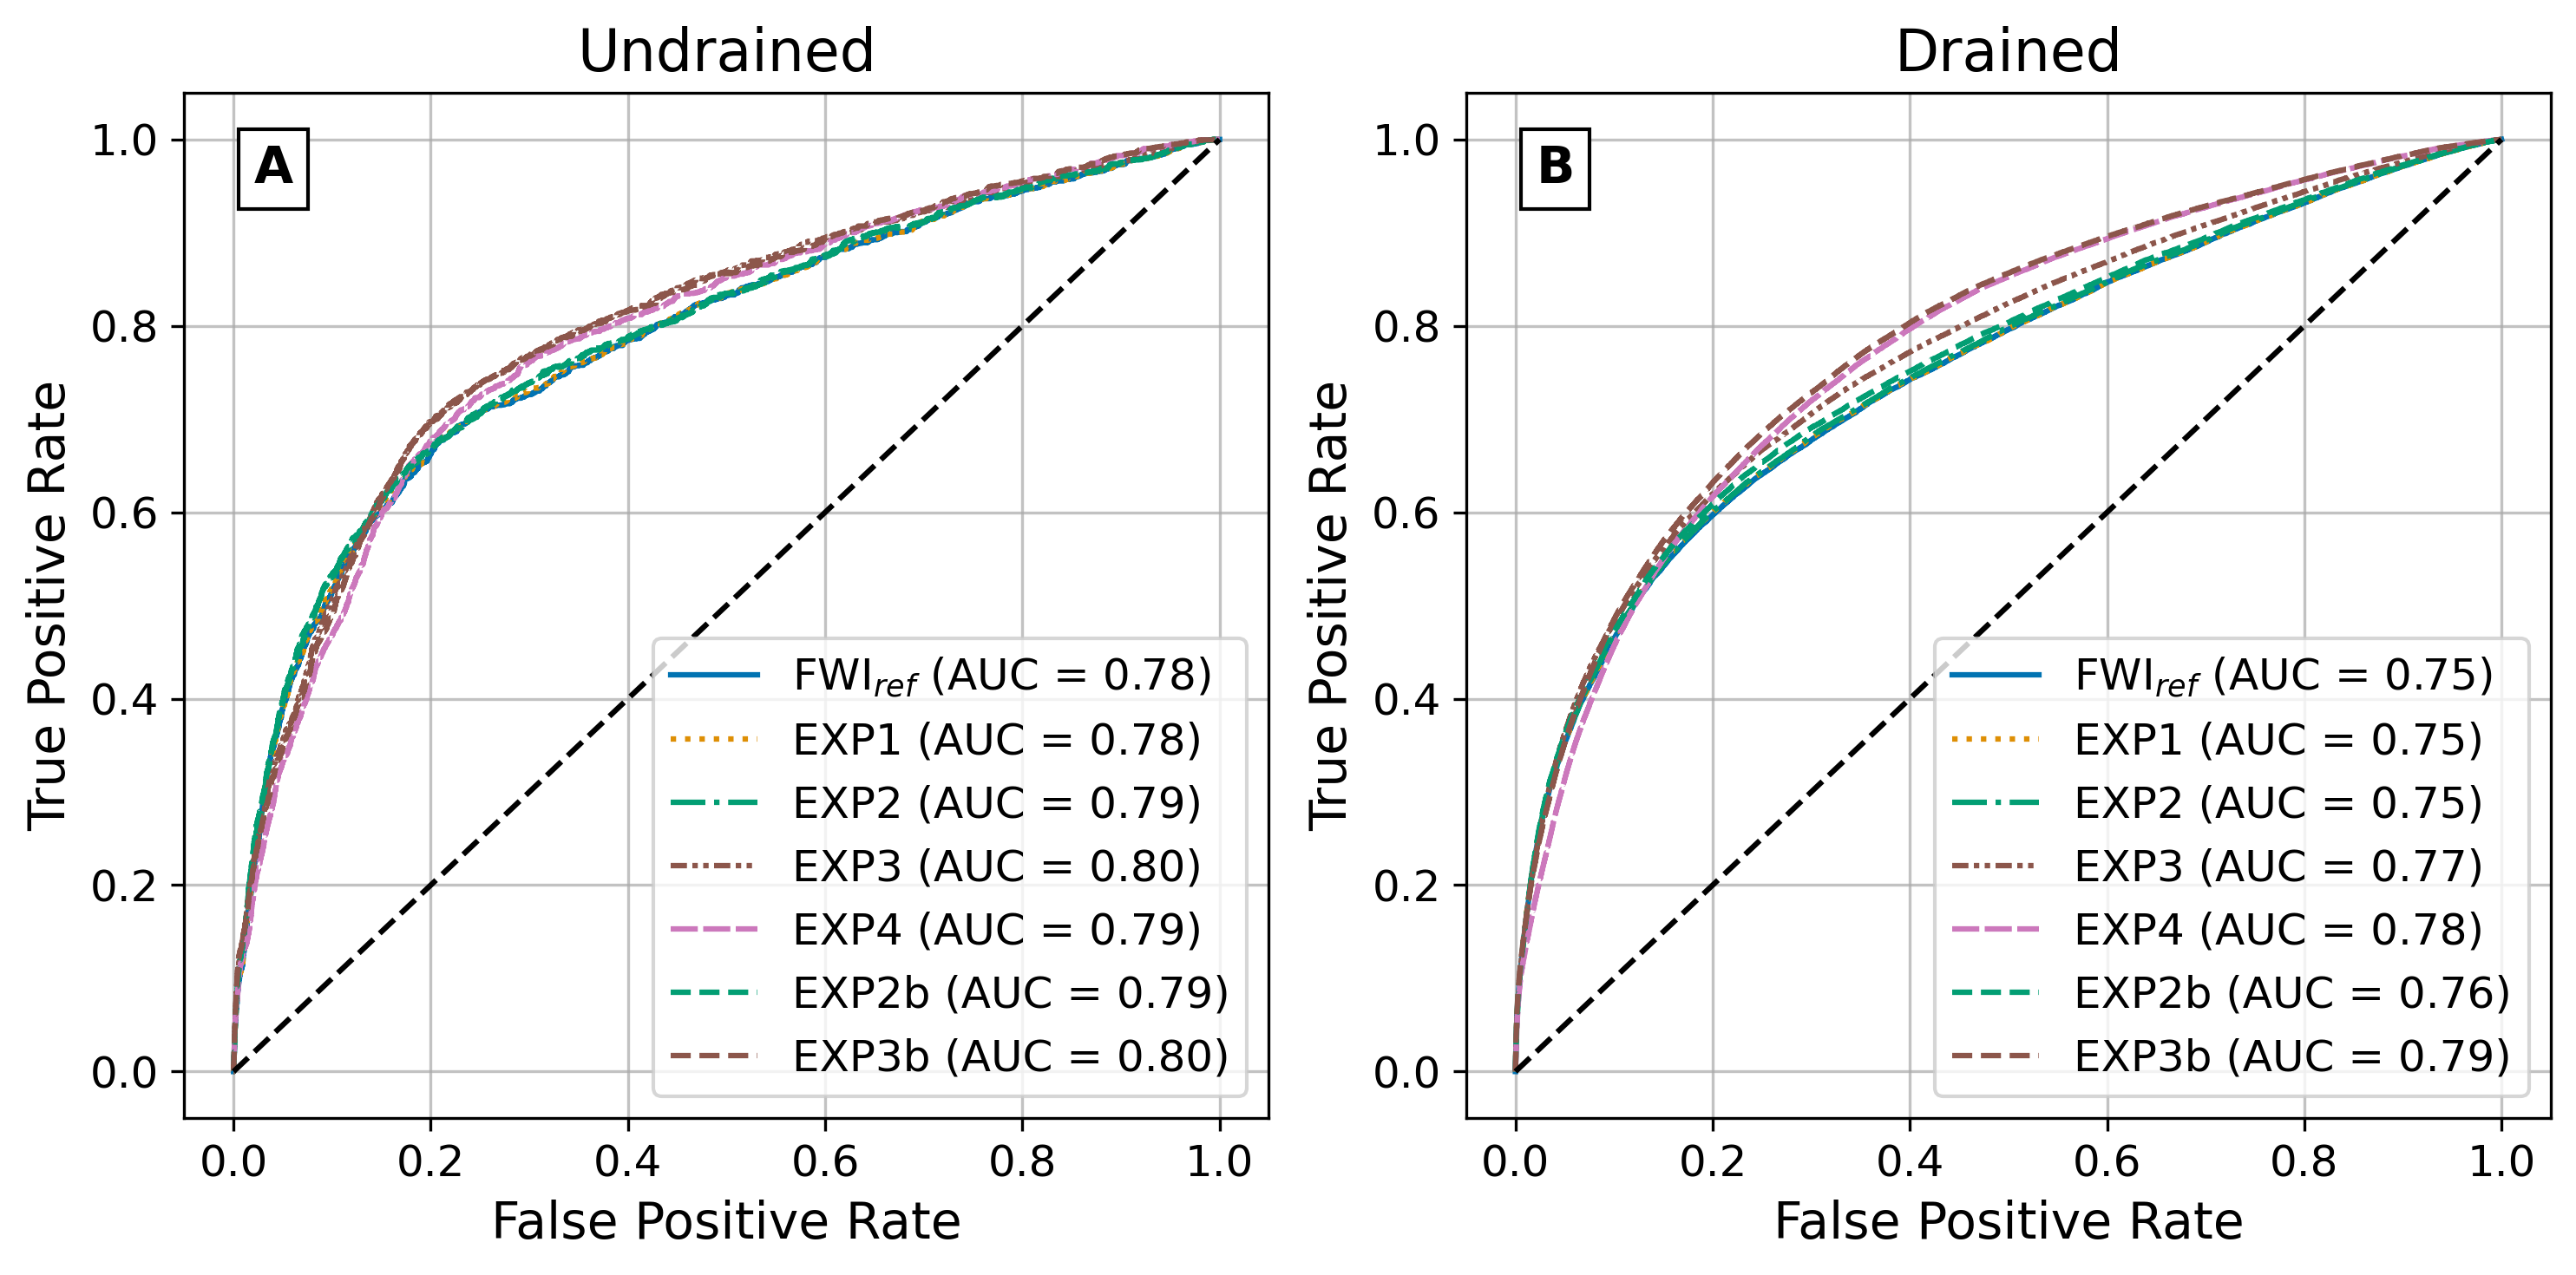

In [8]:
fig = plt.figure(layout='constrained', figsize=(10,5), dpi=300)
ax = fig.subplot_mosaic(
    """
    AB
    """
)
# ---------------------------------------------------------------------------------------------
# NATURAL PEATLANDS
# ---------------------------------------------------------------------------------------------
## Reference:
fpr_M2_nat, tpr_M2_nat, thresholds_M2_nat, auc_M2_nat = compute_roc(
    fires_raster_nat[nonan_M2_nat[:, 0], nonan_M2_nat[:, 1], nonan_M2_nat[:, 2]].flatten(),
    FWI_M2_nat[nonan_M2_nat[:, 0], nonan_M2_nat[:, 1], nonan_M2_nat[:, 2]].flatten())
ax['A'].plot(fpr_M2_nat, tpr_M2_nat, color=c_ref, ls=ls_ref, label='FWI$_{ref}$ (AUC = %0.2f)' % auc_M2_nat)

## EXP1:
fpr_EXP1_nat, tpr_EXP1_nat, thresholds_EXP1_nat, auc_EXP1_nat = \
    compute_roc(fires_raster_nat[nonan_EXP1_nat[:, 0], nonan_EXP1_nat[:, 1], nonan_EXP1_nat[:, 2]].flatten(),
                FWI_EXP1_nat[nonan_EXP1_nat[:, 0], nonan_EXP1_nat[:, 1], nonan_EXP1_nat[:, 2]].flatten())
ax['A'].plot(fpr_EXP1_nat, tpr_EXP1_nat, color=c_EXP1, ls=ls_EXP1, label='EXP1 (AUC = %0.2f)' % auc_EXP1_nat)

## EXP2:
fpr_EXP2_nat, tpr_EXP2_nat, thresholds_EXP2_nat, auc_EXP2_nat = \
    compute_roc(fires_raster_nat[nonan_EXP2_nat[:, 0], nonan_EXP2_nat[:, 1], nonan_EXP2_nat[:, 2]].flatten(),
                FWI_EXP2_nat[nonan_EXP2_nat[:, 0], nonan_EXP2_nat[:, 1], nonan_EXP2_nat[:, 2]].flatten())
ax['A'].plot(fpr_EXP2_nat, tpr_EXP2_nat, color=c_EXP2, ls=ls_EXP2, label='EXP2 (AUC = %0.2f)' % auc_EXP2_nat)

## EXP3:
fpr_EXP3_nat, tpr_EXP3_nat, thresholds_EXP3_nat, auc_EXP3_nat = \
    compute_roc(fires_raster_nat[nonan_EXP3_nat[:, 0], nonan_EXP3_nat[:, 1], nonan_EXP3_nat[:, 2]].flatten(),
                FWI_EXP3_nat[nonan_EXP3_nat[:, 0], nonan_EXP3_nat[:, 1], nonan_EXP3_nat[:, 2]].flatten())
ax['A'].plot(fpr_EXP3_nat, tpr_EXP3_nat, color=c_EXP3, ls=ls_EXP3, label='EXP3 (AUC = %0.2f)' % auc_EXP3_nat)

## EXP4:
fpr_EXP4_nat, tpr_EXP4_nat, thresholds_EXP4_nat, auc_EXP4_nat = \
    compute_roc(fires_raster_nat[nonan_EXP4_nat[:, 0], nonan_EXP4_nat[:, 1], nonan_EXP4_nat[:, 2]].flatten(),
                FWI_EXP4_nat[nonan_EXP4_nat[:, 0], nonan_EXP4_nat[:, 1], nonan_EXP4_nat[:, 2]].flatten())
ax['A'].plot(fpr_EXP4_nat, tpr_EXP4_nat, color=c_EXP4, ls=ls_EXP4, label='EXP4 (AUC = %0.2f)' % auc_EXP4_nat)

## EXP2b:
fpr_EXP2b_nat, tpr_EXP2b_nat, thresholds_EXP2b_nat, auc_EXP2b_nat = \
    compute_roc(fires_raster_nat[nonan_EXP2b_nat[:, 0], nonan_EXP2b_nat[:, 1], nonan_EXP2b_nat[:, 2]].flatten(),
                FWI_EXP2b_nat[nonan_EXP2b_nat[:, 0], nonan_EXP2b_nat[:, 1], nonan_EXP2b_nat[:, 2]].flatten())
ax['A'].plot(fpr_EXP2b_nat, tpr_EXP2b_nat, color=c_EXP2b, ls=ls_EXP2b, label='EXP2b (AUC = %0.2f)' %
                                                                             auc_EXP2b_nat)

## EXP3b:
fpr_EXP3b_nat, tpr_EXP3b_nat, thresholds_EXP3b_nat, auc_EXP3b_nat = \
    compute_roc(fires_raster_nat[nonan_EXP3b_nat[:, 0], nonan_EXP3b_nat[:, 1], nonan_EXP3b_nat[:, 2]].flatten(),
                FWI_EXP3b_nat[nonan_EXP3b_nat[:, 0], nonan_EXP3b_nat[:, 1], nonan_EXP3b_nat[:, 2]].flatten())
ax['A'].plot(fpr_EXP3b_nat, tpr_EXP3b_nat, color=c_EXP3b, ls=ls_EXP3b, label='EXP3b (AUC = %0.2f)' %
                                                                             auc_EXP3b_nat)

# Beautify the plot:
ax['A'].set_title('Undrained', fontsize=font_subtitle)
ax['A'].plot([0, 1], [0, 1], 'k--')  # Plot the 1:1 line

ax['A'].set_xlabel('False Positive Rate', fontsize=font_axes)
ax['A'].set_ylabel('True Positive Rate', fontsize=font_axes)
ax['A'].legend(fontsize=font_legend, loc='lower right')
ax['A'].tick_params(axis='both', labelsize=font_ticklabels)

# ---------------------------------------------------------------------------------------------
# DRAINED PEATLANDS
# ---------------------------------------------------------------------------------------------
 ## Reference:
fpr_M2_dra, tpr_M2_dra, thresholds_M2_dra, auc_M2_dra = compute_roc(fires_raster_dra[nonan_M2_dra[:, 0], nonan_M2_dra[:, 1], nonan_M2_dra[:, 2]].flatten(),
                                                                    FWI_M2_dra[nonan_M2_dra[:, 0], nonan_M2_dra[:, 1], nonan_M2_dra[:, 2]].flatten())
ax['B'].plot(fpr_M2_dra, tpr_M2_dra, color=c_ref, ls=ls_ref, label='FWI$_{ref}$ (AUC = %0.2f)' % auc_M2_dra)

## EXP1:
fpr_EXP1_dra, tpr_EXP1_dra, thresholds_EXP1_dra, auc_EXP1_dra = compute_roc(
    fires_raster_dra[nonan_EXP1_dra[:, 0], nonan_EXP1_dra[:, 1], nonan_EXP1_dra[:, 2]].flatten(),
    FWI_EXP1_dra[nonan_EXP1_dra[:, 0], nonan_EXP1_dra[:, 1], nonan_EXP1_dra[:, 2]].flatten())
ax['B'].plot(fpr_EXP1_dra, tpr_EXP1_dra, color=c_EXP1, ls=ls_EXP1, label='EXP1 (AUC = %0.2f)' % auc_EXP1_dra)

## EXP2:
fpr_EXP2_dra, tpr_EXP2_dra, thresholds_EXP2_dra, auc_EXP2_dra = \
    compute_roc(fires_raster_dra[nonan_EXP2_dra[:, 0], nonan_EXP2_dra[:, 1], nonan_EXP2_dra[:, 2]].flatten(),
                FWI_EXP2_dra[nonan_EXP2_dra[:, 0], nonan_EXP2_dra[:, 1], nonan_EXP2_dra[:, 2]].flatten())
ax['B'].plot(fpr_EXP2_dra, tpr_EXP2_dra, color=c_EXP2, ls=ls_EXP2, label='EXP2 (AUC = %0.2f)' % auc_EXP2_dra)

## EXP3:
fpr_EXP3_dra, tpr_EXP3_dra, thresholds_EXP3_dra, auc_EXP3_dra = \
    compute_roc(fires_raster_dra[nonan_EXP3_dra[:, 0], nonan_EXP3_dra[:, 1], nonan_EXP3_dra[:, 2]].flatten(),
                FWI_EXP3_dra[nonan_EXP3_dra[:, 0], nonan_EXP3_dra[:, 1], nonan_EXP3_dra[:, 2]].flatten())
ax['B'].plot(fpr_EXP3_dra, tpr_EXP3_dra, color=c_EXP3, ls=ls_EXP3, label='EXP3 (AUC = %0.2f)' % auc_EXP3_dra)

## EXP4:
fpr_EXP4_dra, tpr_EXP4_dra, thresholds_EXP4_dra, auc_EXP4_dra = \
    compute_roc(fires_raster_dra[nonan_EXP4_dra[:, 0], nonan_EXP4_dra[:, 1], nonan_EXP4_dra[:, 2]].flatten(),
                FWI_EXP4_dra[nonan_EXP4_dra[:, 0], nonan_EXP4_dra[:, 1], nonan_EXP4_dra[:, 2]].flatten())
ax['B'].plot(fpr_EXP4_dra, tpr_EXP4_dra, color=c_EXP4, ls=ls_EXP4, label='EXP4 (AUC = %0.2f)' % auc_EXP4_dra)

## EXP2b:
fpr_EXP2b_dra, tpr_EXP2b_dra, thresholds_EXP2b_dra, auc_EXP2b_dra = \
    compute_roc(fires_raster_dra[nonan_EXP2b_dra[:, 0], nonan_EXP2b_dra[:, 1], nonan_EXP2b_dra[:, 2]].flatten(),
                FWI_EXP2b_dra[nonan_EXP2b_dra[:, 0], nonan_EXP2b_dra[:, 1], nonan_EXP2b_dra[:, 2]].flatten())
ax['B'].plot(fpr_EXP2b_dra, tpr_EXP2b_dra, color=c_EXP2b, ls=ls_EXP2b, label='EXP2b (AUC = %0.2f)' %
                                                                             auc_EXP2b_dra)

## EXP3b:
fpr_EXP3b_dra, tpr_EXP3b_dra, thresholds_EXP3b_dra, auc_EXP3b_dra = \
    compute_roc(fires_raster_dra[nonan_EXP3b_dra[:, 0], nonan_EXP3b_dra[:, 1], nonan_EXP3b_dra[:, 2]].flatten(),
                FWI_EXP3b_dra[nonan_EXP3b_dra[:, 0], nonan_EXP3b_dra[:, 1], nonan_EXP3b_dra[:, 2]].flatten())
ax['B'].plot(fpr_EXP3b_dra, tpr_EXP3b_dra, color=c_EXP3b, ls=ls_EXP3b, label='EXP3b (AUC = %0.2f)' %
                                                                             auc_EXP3b_dra)

# Beautify the plot:
ax['B'].set_title('Drained', fontsize=font_subtitle)
ax['B'].plot([0, 1], [0, 1], 'k--')  # Plot the 1:1 line

ax['B'].set_xlabel('False Positive Rate', fontsize=font_axes)
ax['B'].set_ylabel('True Positive Rate', fontsize=font_axes)
ax['B'].legend(fontsize=font_legend, loc='lower right')
ax['B'].tick_params(axis='both', labelsize=font_ticklabels)

fig.tight_layout()

# Add a, b, c, etc to the figures
ax['A'].annotate('A', xy=(0.1, 0.95), xycoords='axes fraction', fontsize=14, weight='bold', ha='right', va='top', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=0.3))
ax['B'].annotate('B', xy=(0.1, 0.95), xycoords='axes fraction', fontsize=14, weight='bold', ha='right', va='top', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=0.3))

ax['A'].grid(True, which='both', color='darkgrey', alpha=0.7)
ax['B'].grid(True, which='both', color='darkgrey', alpha=0.7)

plt.savefig(os.path.join(path_figs, 'ROC_all'))

# CHECK ROC FOR MOISTURE CODES

In [9]:
# Load the data
FFMC_M2_nat = ds_ref_nat['MERRA2_FFMC'][0:6209, :, :].data
DMC_M2_nat = ds_ref_nat['MERRA2_DMC'][0:6209, :, :].data
DC_M2_nat = ds_ref_nat['MERRA2_DC'][0:6209, :, :].data
ISI_M2_nat = ds_ref_nat['MERRA2_ISI'][0:6209, :, :].data
BUI_M2_nat = ds_ref_nat['MERRA2_BUI'][0:6209, :, :].data

FFMC_M2_dra = ds_ref_dra['MERRA2_FFMC'][0:6209, :, :].data
DMC_M2_dra = ds_ref_dra['MERRA2_DMC'][0:6209, :, :].data
DC_M2_dra = ds_ref_dra['MERRA2_DC'][0:6209, :, :].data
ISI_M2_dra = ds_ref_dra['MERRA2_ISI'][0:6209, :, :].data
BUI_M2_dra = ds_ref_dra['MERRA2_BUI'][0:6209, :, :].data

In [10]:
nonan_FFMC_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(FFMC_M2_nat)))
nonan_DMC_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(DMC_M2_nat)))
nonan_DC_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(DC_M2_nat)))
nonan_ISI_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(ISI_M2_nat)))
nonan_BUI_nat = np.argwhere((~np.isnan(fires_raster_nat)) & (~np.isnan(BUI_M2_nat)))

nonan_FFMC_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(FFMC_M2_dra)))
nonan_DMC_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(DMC_M2_dra)))
nonan_DC_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(DC_M2_dra)))
nonan_ISI_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(ISI_M2_dra)))
nonan_BUI_dra = np.argwhere((~np.isnan(fires_raster_dra)) & (~np.isnan(BUI_M2_dra)))

/tmp/ipykernel_7389/3535419683.py:101: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


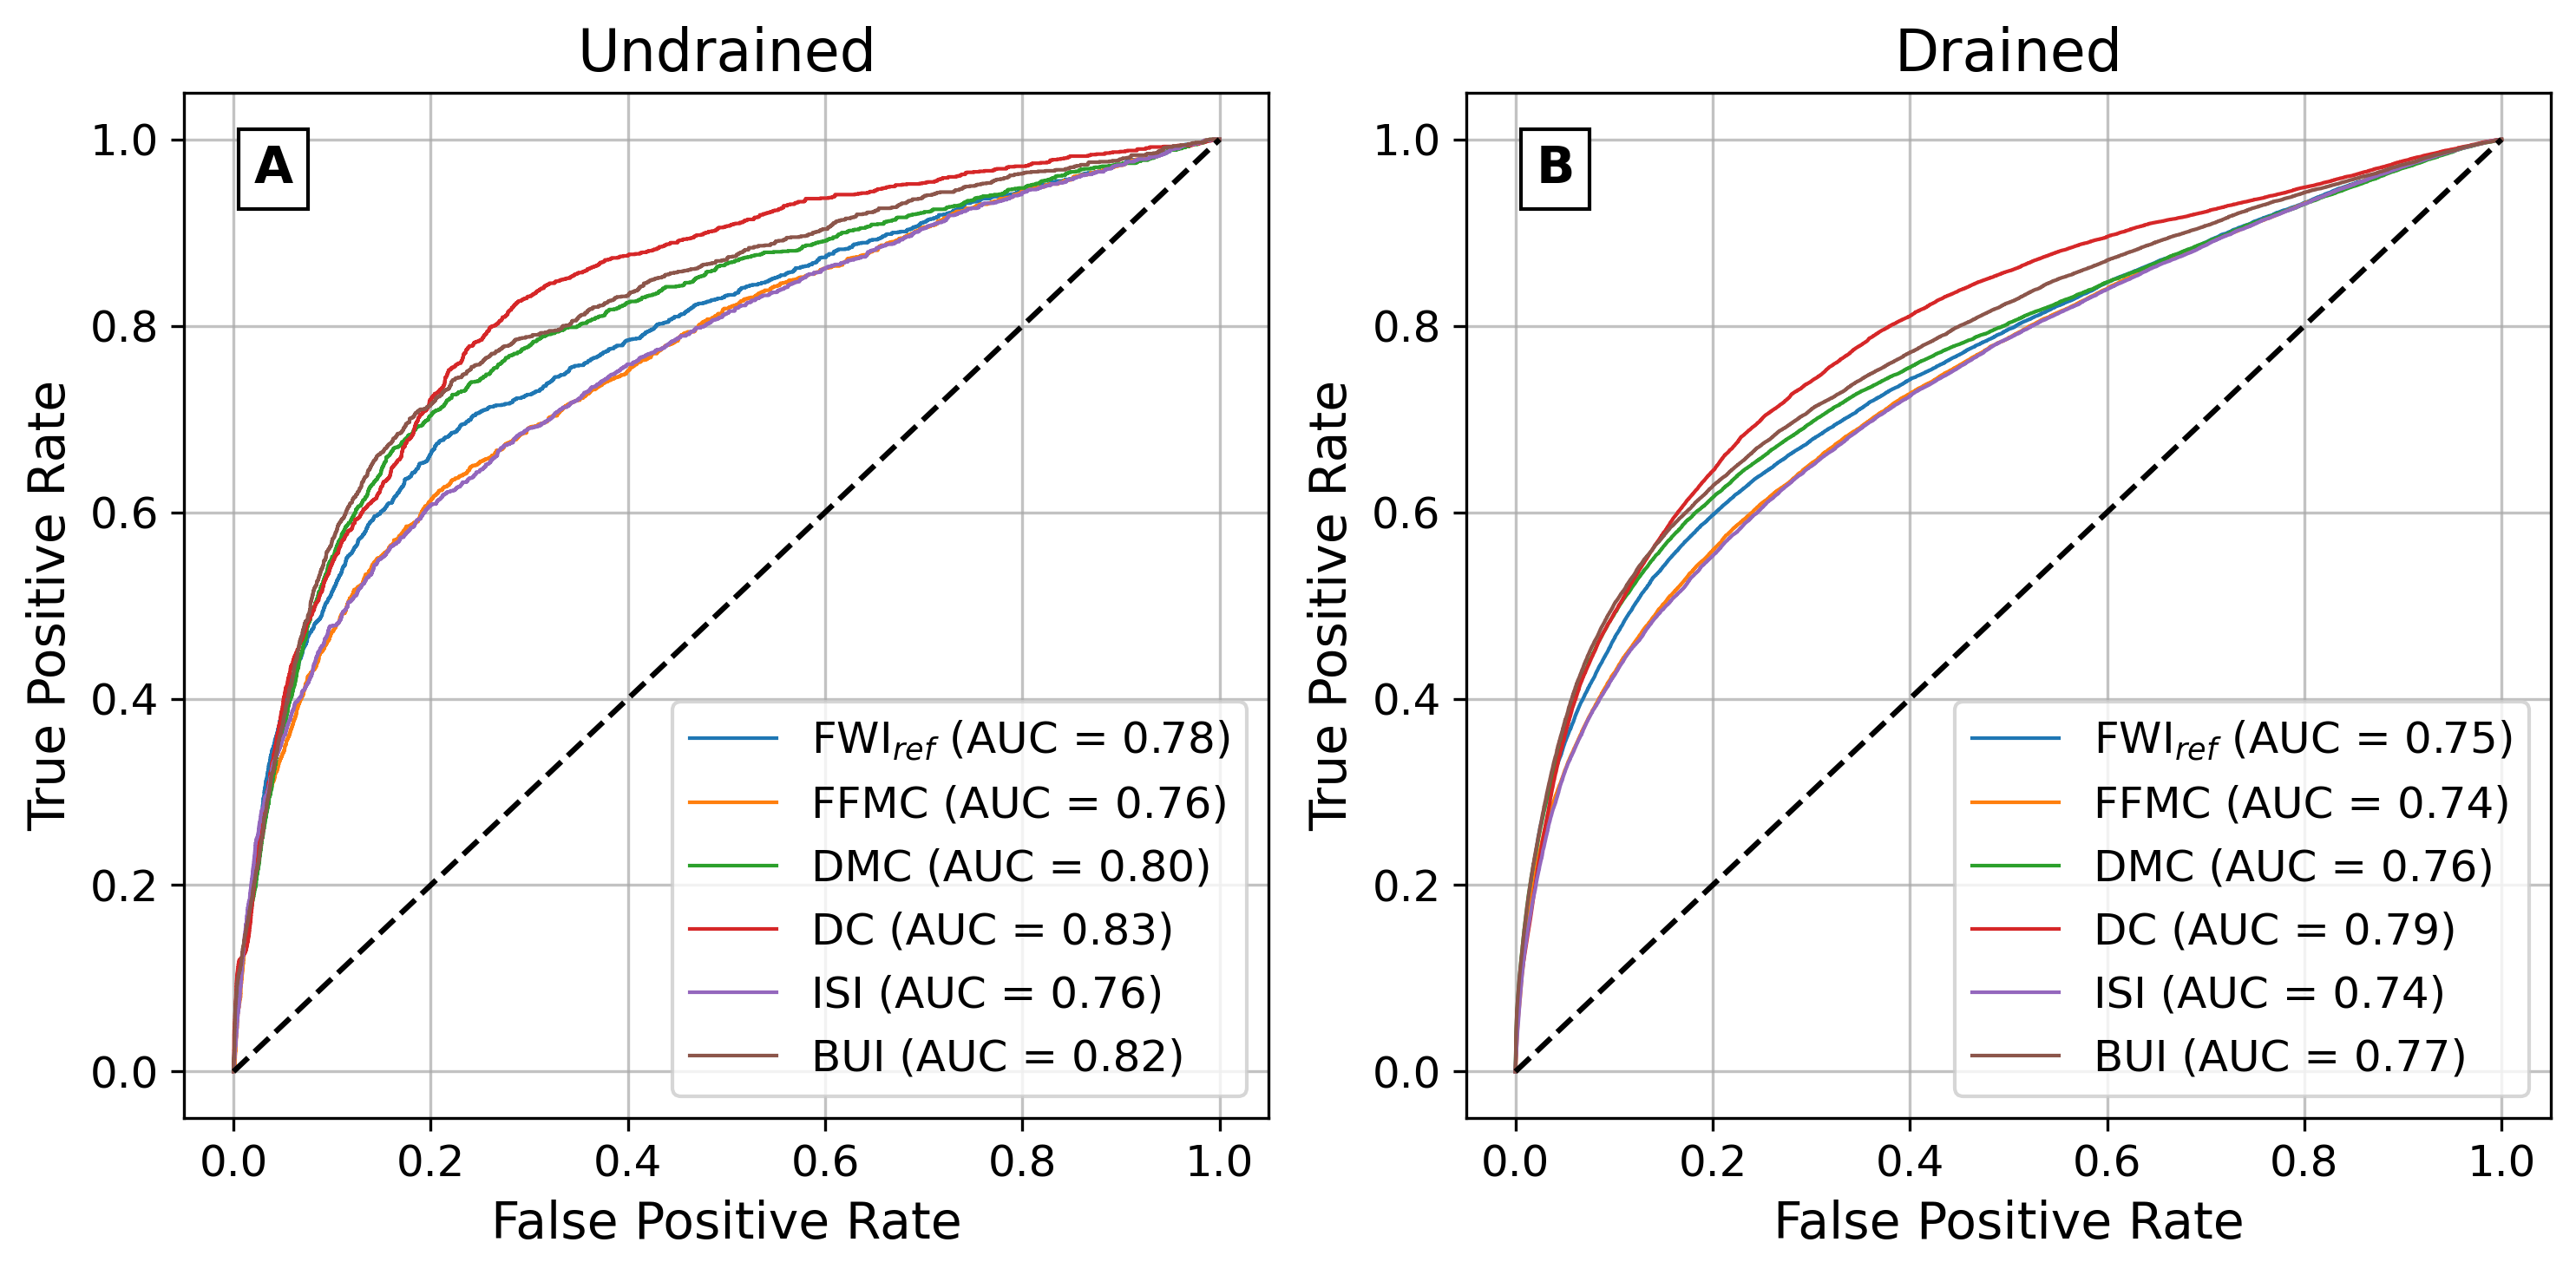

In [16]:
'''-------------------------------------------------Plotting-------------------------------------------------'''
fig = plt.figure(layout='constrained', figsize=(10,5), dpi=300)
ax = fig.subplot_mosaic(
    """
    AB
    """
)
# ---------------------------------------------------------------------------------------------
# NATURAL PEATLANDS
# ---------------------------------------------------------------------------------------------
## Reference:
fpr_M2_nat, tpr_M2_nat, _, auc_M2_nat = compute_roc(
    fires_raster_nat[nonan_M2_nat[:, 0], nonan_M2_nat[:, 1], nonan_M2_nat[:, 2]].flatten(),
    FWI_M2_nat[nonan_M2_nat[:, 0], nonan_M2_nat[:, 1], nonan_M2_nat[:, 2]].flatten())
ax['A'].plot(fpr_M2_nat, tpr_M2_nat, color='tab:blue', label='FWI$_{ref}$ (AUC = %0.2f)' % auc_M2_nat, linewidth=1)

## FFMC:
fpr_FFMC_nat, tpr_FFMC_nat, _, auc_FFMC_nat = compute_roc(
    fires_raster_nat[nonan_FFMC_nat[:, 0], nonan_FFMC_nat[:, 1], nonan_FFMC_nat[:, 2]].flatten(),
    FFMC_M2_nat[nonan_FFMC_nat[:, 0], nonan_FFMC_nat[:, 1], nonan_FFMC_nat[:, 2]].flatten())
ax['A'].plot(fpr_FFMC_nat, tpr_FFMC_nat, color='tab:orange', label='FFMC (AUC = %0.2f)' % auc_FFMC_nat, linewidth=1)
## DMC
fpr_DMC_nat, tpr_DMC_nat, _, auc_DMC_nat = compute_roc(
    fires_raster_nat[nonan_DMC_nat[:, 0], nonan_DMC_nat[:, 1], nonan_DMC_nat[:, 2]].flatten(),
    DMC_M2_nat[nonan_DMC_nat[:, 0], nonan_DMC_nat[:, 1], nonan_DMC_nat[:, 2]].flatten())
ax['A'].plot(fpr_DMC_nat, tpr_DMC_nat, color='tab:green', label='DMC (AUC = %0.2f)' % auc_DMC_nat, linewidth=1)

# DC
fpr_DC_nat, tpr_DC_nat, _, auc_DC_nat = compute_roc(
    fires_raster_nat[nonan_DC_nat[:, 0], nonan_DC_nat[:, 1], nonan_DC_nat[:, 2]].flatten(),
    DC_M2_nat[nonan_DC_nat[:, 0], nonan_DC_nat[:, 1], nonan_DC_nat[:, 2]].flatten())
ax['A'].plot(fpr_DC_nat, tpr_DC_nat, color='tab:red', label='DC (AUC = %0.2f)' % auc_DC_nat, linewidth=1)

# ISI
fpr_ISI_nat, tpr_ISI_nat, _, auc_ISI_nat = compute_roc(
    fires_raster_nat[nonan_ISI_nat[:, 0], nonan_ISI_nat[:, 1], nonan_ISI_nat[:, 2]].flatten(),
    ISI_M2_nat[nonan_ISI_nat[:, 0], nonan_ISI_nat[:, 1], nonan_ISI_nat[:, 2]].flatten())
ax['A'].plot(fpr_ISI_nat, tpr_ISI_nat, color='tab:purple', label='ISI (AUC = %0.2f)' % auc_ISI_nat, linewidth=1)

# BUI
fpr_BUI_nat, tpr_BUI_nat, _, auc_BUI_nat = compute_roc(
    fires_raster_nat[nonan_BUI_nat[:, 0], nonan_BUI_nat[:, 1], nonan_BUI_nat[:, 2]].flatten(),
    BUI_M2_nat[nonan_BUI_nat[:, 0], nonan_BUI_nat[:, 1], nonan_BUI_nat[:, 2]].flatten())
ax['A'].plot(fpr_BUI_nat, tpr_BUI_nat, color='tab:brown', label='BUI (AUC = %0.2f)' % auc_BUI_nat, linewidth=1)

# Beautify the plot:
ax['A'].set_title('Undrained', fontsize=font_subtitle)
ax['A'].plot([0, 1], [0, 1], 'k--')  # Plot the 1:1 line

ax['A'].set_xlabel('False Positive Rate', fontsize=font_axes)
ax['A'].set_ylabel('True Positive Rate', fontsize=font_axes)
ax['A'].legend(fontsize=font_legend, loc='lower right')
ax['A'].tick_params(axis='both', labelsize=font_ticklabels)

# ---------------------------------------------------------------------------------------------
# DRAINED PEATLANDS
# ---------------------------------------------------------------------------------------------
fpr_M2_dra, tpr_M2_dra, _, auc_M2_dra = compute_roc(
    fires_raster_dra[nonan_M2_dra[:, 0], nonan_M2_dra[:, 1], nonan_M2_dra[:, 2]].flatten(), 
    FWI_M2_dra[nonan_M2_dra[:, 0], nonan_M2_dra[:, 1], nonan_M2_dra[:, 2]].flatten())
ax['B'].plot(fpr_M2_dra, tpr_M2_dra, color='tab:blue', label='FWI$_{ref}$ (AUC = %0.2f)' % auc_M2_dra, linewidth=1)

## FFMC:
fpr_FFMC_dra, tpr_FFMC_dra, _, auc_FFMC_dra = compute_roc(
    fires_raster_dra[nonan_FFMC_dra[:, 0], nonan_FFMC_dra[:, 1], nonan_FFMC_dra[:, 2]].flatten(),
    FFMC_M2_dra[nonan_FFMC_dra[:, 0], nonan_FFMC_dra[:, 1], nonan_FFMC_dra[:, 2]].flatten())
ax['B'].plot(fpr_FFMC_dra, tpr_FFMC_dra, color='tab:orange', label='FFMC (AUC = %0.2f)' % auc_FFMC_dra, linewidth=1)

## DMC
fpr_DMC_dra, tpr_DMC_dra, _, auc_DMC_dra = compute_roc(
    fires_raster_dra[nonan_DMC_dra[:, 0], nonan_DMC_dra[:, 1], nonan_DMC_dra[:, 2]].flatten(),
    DMC_M2_dra[nonan_DMC_dra[:, 0], nonan_DMC_dra[:, 1], nonan_DMC_dra[:, 2]].flatten())
ax['B'].plot(fpr_DMC_dra, tpr_DMC_dra, color='tab:green', label='DMC (AUC = %0.2f)' % auc_DMC_dra, linewidth=1)

# DC
fpr_DC_dra, tpr_DC_dra, _, auc_DC_dra = compute_roc(
    fires_raster_dra[nonan_DC_dra[:, 0], nonan_DC_dra[:, 1], nonan_DC_dra[:, 2]].flatten(),
    DC_M2_dra[nonan_DC_dra[:, 0], nonan_DC_dra[:, 1], nonan_DC_dra[:, 2]].flatten())
ax['B'].plot(fpr_DC_dra, tpr_DC_dra, color='tab:red', label='DC (AUC = %0.2f)' % auc_DC_dra, linewidth=1)

# ISI
fpr_ISI_dra, tpr_ISI_dra, _, auc_ISI_dra = compute_roc(
    fires_raster_dra[nonan_ISI_dra[:, 0], nonan_ISI_dra[:, 1], nonan_ISI_dra[:, 2]].flatten(),
    ISI_M2_dra[nonan_ISI_dra[:, 0], nonan_ISI_dra[:, 1], nonan_ISI_dra[:, 2]].flatten())
ax['B'].plot(fpr_ISI_dra, tpr_ISI_dra, color='tab:purple', label='ISI (AUC = %0.2f)' % auc_ISI_dra, linewidth=1)
# BUI
fpr_BUI_dra, tpr_BUI_dra, _, auc_BUI_dra = compute_roc(
    fires_raster_dra[nonan_BUI_dra[:, 0], nonan_BUI_dra[:, 1], nonan_BUI_dra[:, 2]].flatten(),
    BUI_M2_dra[nonan_BUI_dra[:, 0], nonan_BUI_dra[:, 1], nonan_BUI_dra[:, 2]].flatten())
ax['B'].plot(fpr_BUI_dra, tpr_BUI_dra, color='tab:brown', label='BUI (AUC = %0.2f)' % auc_BUI_dra, linewidth=1)

# Beautify the plot:
ax['B'].set_title('Drained', fontsize=font_subtitle)
ax['B'].plot([0, 1], [0, 1], 'k--')  # Plot the 1:1 line

ax['B'].set_xlabel('False Positive Rate', fontsize=font_axes)
ax['B'].set_ylabel('True Positive Rate', fontsize=font_axes)
ax['B'].legend(fontsize=font_legend, loc='lower right')
ax['B'].tick_params(axis='both', labelsize=font_ticklabels)

fig.tight_layout()

# Add a, b, c, etc to the figures
ax['A'].annotate('A', xy=(0.1, 0.95), xycoords='axes fraction', fontsize=14, weight='bold', ha='right', va='top', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=0.3))
ax['B'].annotate('B', xy=(0.1, 0.95), xycoords='axes fraction', fontsize=14, weight='bold', ha='right', va='top', 
                  bbox=dict(facecolor='white', edgecolor='black', boxstyle='square', pad=0.3))

ax['A'].grid(True, which='both', color='darkgrey', alpha=0.7)
ax['B'].grid(True, which='both', color='darkgrey', alpha=0.7)

plt.savefig(os.path.join(path_figs, 'ROC_FWI_components'))

## Check if the AUC values are significantly different

In [ ]:
from scipy.stats import shapiro

M2_nat_stat, M2_nat_p = shapiro(auc_all_M2_nat)
M2_dra_stat, M2_dra_p = shapiro(auc_all_M2_dra)
EXP3b_nat_stat, EXP3b_nat_p = shapiro(auc_all_EXP3b_nat)
EXP3b_dra_stat, EXP3b_dra_p = shapiro(auc_all_EXP3b_dra)

In [ ]:
print("Reference, natural p-value: {}".format(M2_nat_p))
print("Reference, drained p-value: {}".format(M2_dra_p))
print("EXP3b, natural p-value: {}".format(EXP3b_nat_p))
print("EXP3b, drained p-value: {}".format(EXP3b_dra_p))

In [ ]:
print("Natural t-test: {}".format(scipy.stats.ttest_ind(auc_all_M2_nat, auc_all_EXP3b_nat)))
print("Drained t-test: {}".format(scipy.stats.ttest_ind(auc_all_M2_dra, auc_all_EXP3b_dra)))